# YOLOv2 training

This notebook illustrates a complete `YOLOv2` training pipeline. To get more details on the different steps, check this [introduction project](https://github.com/yui-mhcp/base_dl_project), especially the `example_classifier` notebook.

## Imports + model initialization

The `nb_class` is recommanded to be higher than 1, as the model uses the `softmax` activation function to compute the scores for each label (which requires multiple classes, even for binary classification). 

In [7]:
import importlib
import numpy as np
import pandas as pd

from keras import tree

from models import YOLO, get_pretrained
from utils import set_display_options, plot, plot_multiple, plot_confusion_matrix
from utils.keras_utils import show_version, ops
from utils.datasets import get_dataset, prepare_dataset, train_test_split, test_dataset_time

set_display_options()

model_name = 'yolo_kangaroo'
show_version()

Keras version : 3.3.3 - backend (tensorflow) : 2.16.1


In [2]:
model = YOLO(
    labels = 'kangaroo', nb_class = 5, name = model_name
)

print(model)

Loading weights from pretrained_models/pretrained_weights/yolo_backend/full_yolo_backend.h5


Initializing model with kwargs : {'architecture': 'yolo', 'feature_extractor': <Functional name=feature_extractor, built=True>, 'input_shape': (416, 416, 3), 'anchors': [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828], 'nb_class': 5, 'flatten': True, 'randomize': False}
Save `model` to pretrained_models/yolo_kangaroo/saving/ckpt-0000.keras
YOLO `yolo_kangaroo` initialized successfully !

========== yolo_kangaroo ==========
Model instance `model`
- Inputs 	: (None, 416, 416, 3)
- Outputs 	: (None, 13, 13, 5, 10)
- Number of layers 	: 76
- Number of parameters 	: 50.599 Millions
- Model not compiled yet

Already trained on 0 epochs (0 steps)

- Image size : (416, 416, 3)
- Normalization schema : None
- Labels (n = 5) : ['kangaroo', '', '', '', '']
- Feature extractor : FullYolo



## Model instanciation + dataset loading

Once the model has been created, it can be reloaded simply though its name, with the `get_pretrained` function !

Optimizers and config are tuned for a good training on `Wider Faces`, but they can be easily modified ;) In this case, the `SGD` optimizer has shown better results than `Adam`, which may not be the case on your dataset !

The dataset loaded in this example is the `kangaroo` toy dataset, allowing for fast training. This is more funny for a first experiment to get acceptable performances within a few minutes ! :)

In [4]:
model = get_pretrained(model_name)

model.compile(
    optimizer = 'sgd',
    optimizer_config = {
        'lr' : {'name' : 'WarmupScheduler', 'maxval' : 5e-3,'minval' : 1e-4, 'factor' : 1024, 'warmup_steps' : 4096}
    }
)

print(model)

Model compiled successfully !
- Optimizer 	: {'name': 'SGD', 'learning_rate': {'module': 'custom_train_objects.optimizers.lr_schedulers', 'class_name': 'WarmupScheduler', 'config': {'minval': 9.999999747378752e-05, 'maxval': 0.004999999888241291, 'factor': 1024.0, 'warmup_steps': 4096}, 'registered_name': 'WarmupScheduler'}, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'momentum': 0.0, 'nesterov': False}


========== yolo_kangaroo ==========
Model instance `model`
- Inputs 	: (None, 416, 416, 3)
- Outputs 	: (None, 13, 13, 5, 10)
- Number of layers 	: 76
- Number of parameters 	: 50.599 Millions

- Optimizer 	: {'name': 'SGD', 'learning_rate': {'module': 'custom_train_objects.optimizers.lr_schedulers', 'class_name': 'WarmupScheduler', 'config': {'minval': 9.999999747378752e-05, 'maxval': 0.004999999888241291, 'fa

In [8]:
dataset_name = 'kangaroo' # 'wider'
ds = get_dataset(dataset_name, pad_boxes = True)

if isinstance(ds, dict):
    train, valid = ds['train'], ds['test']
    print(train)
    print(valid)
elif isinstance(ds, tuple):
    train, valid = ds
    print('train : {} - valid : {}'.format(
        tree.map_structure(np.shape, train), tree.map_structure(np.shape, valid)
    ))
else:
    train, valid = train_test_split(ds, train_size = 0.75, shuffle = True)
    if dataset_name == 'kangaroo': train = train.drop(index = 79)
    print('train : {} - valid : {}'.format(
        tree.map_structure(np.shape, train), tree.map_structure(np.shape, valid)
    ))


Loading dataset kangaroo...
train : (122, 6) - valid : (41, 6)


## Training + history analysis

The `train_times > 1` repeats the dataset multiple times for a single epoch (i.e., `train_times = 8` is roughly equivalent to train the models with 2 times more epochs). 

When the loss becomes less than 0.2 / 0.15, the model seems to be quite good and usable on new images. However, it may be recommanded to stop training after reaching a loss lower than 0.1, which seems to give reall nice results ! The provided `yolo_faces` model has a final loss of 0.07, and seems quite well stable and performant on camera (in *indoor* conditions, not tested *in the wild*).

In [ ]:
model.fit(
    train,
    validation_data = valid,
    
    epochs      = 15,
    batch_size  = 16,
    train_times = 8,
    
    additional_infos = {'dataset' : dataset_name},
    
    augment_prct = 0.25,
    
    add_early_stopping = True,
    patience = 5
)

===== History =====
        loss  loss_class  loss_conf   loss_wh   loss_xy  val_loss  val_loss_class  val_loss_conf  val_loss_wh  val_loss_xy
0   0.610789    0.186216   0.100543  0.240609  0.077194  0.401610        0.074825       0.057734     0.177787     0.096118
1   0.149679    0.015985   0.035232  0.051232  0.047771  0.327562        0.046044       0.031175     0.161328     0.091716
2   0.091119    0.008293   0.023073  0.025065  0.034853  0.261761        0.036863       0.022466     0.112419     0.089632
3   0.070576    0.005701   0.019162  0.017720  0.027929  0.256007        0.032511       0.018034     0.116276     0.089241
4   0.062471    0.004547   0.017139  0.016294  0.024512  0.237460        0.029899       0.015570     0.103142     0.088967
5   0.057239    0.004049   0.015966  0.015287  0.021946  0.238835        0.027981       0.013926     0.107866     0.089187
6   0.051529    0.003548   0.015165  0.013057  0.019956  0.233141        0.026443       0.012956     0.104888     0.088

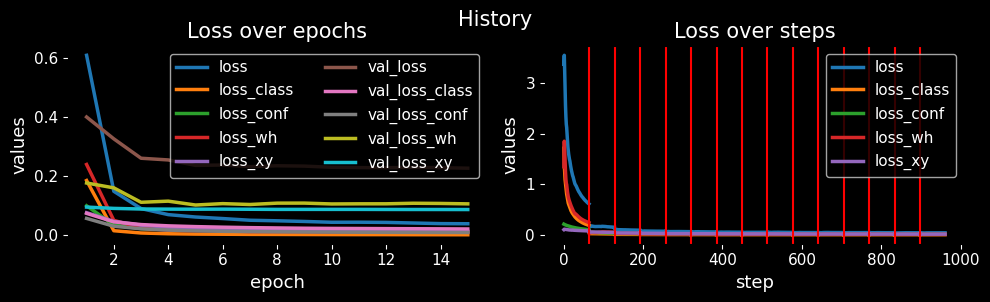

In [25]:
print(model.history)
model.plot_history()

In [26]:
print("Training config :")
print(pd.DataFrame(model.training_logs))
print("\nTraining parameters :")
print(pd.DataFrame(model.training_config))
print("\nTraining informations :")
print(pd.DataFrame(model.training_infos))


Training config :
          start           end       time  interrupted  start_epoch  final_epoch
0  1.716882e+09  1.716882e+09  83.471371        False            0           15

Training parameters :
   batch_size  train_times  add_early_stopping  patience  augment_prct                             augmentation_method  \
0          16            8                True         5          0.25  [noise, brightness, contrast, hue, saturation]   

   epochs  initial_epoch  
0      15              0  

Training informations :
          start           end       time  interrupted  start_epoch  final_epoch  \
0  1.716882e+09  1.716882e+09  83.471371        False            0           15   

                                             dataset         additional_infos  
0  {'train': {'filename': {'# uniques': 122}, 'la...  {'dataset': 'kangaroo'}  


## Prediction

As you can observe in the below results, the model tends to have a good *true positive* (correct detection), but also makes some *false positives* (wrong detection). You can adapt the *true positive rate* and the *false negative rate* by modifying the `obj_threshold` parameter. The `nms_threshold` allows to adjust the suppression of overlapping boxes (i.e. 2 detections that overlap).

For instance, if you put it to `0.65`, you will only have *true positives* (the 2 false positives in the 4th image will be removed) but you will lose some faces (in the 2nd and 5th images) ;)

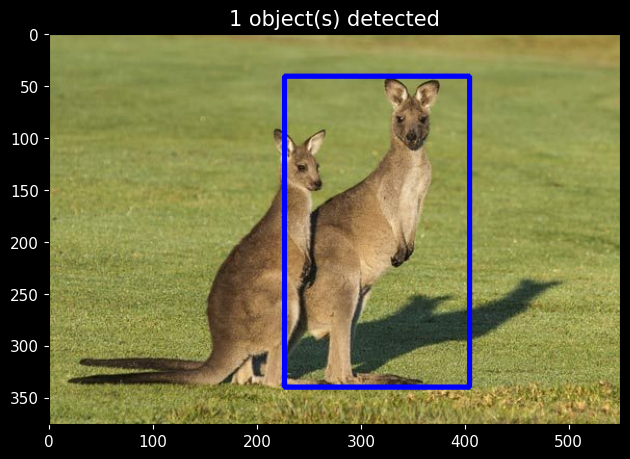

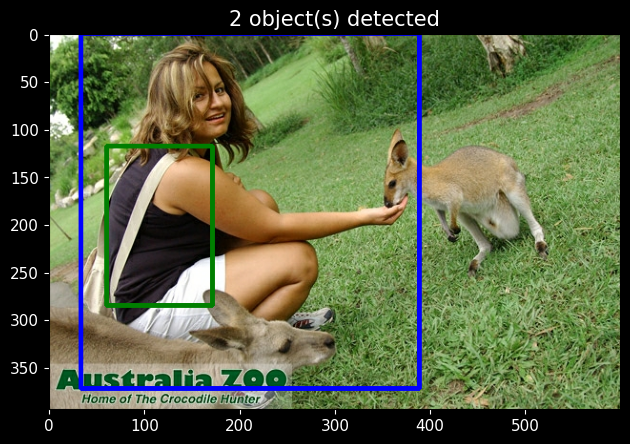

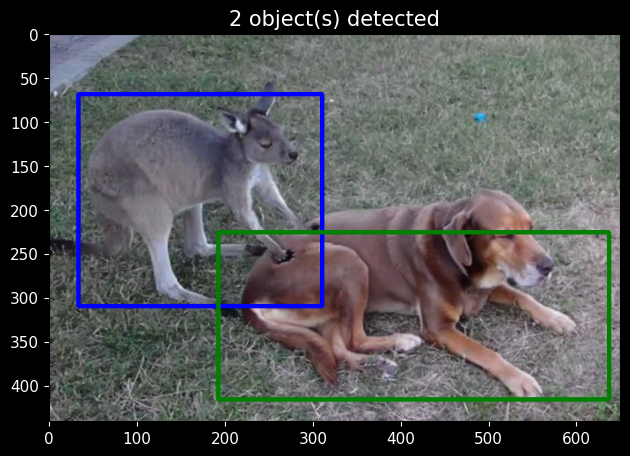

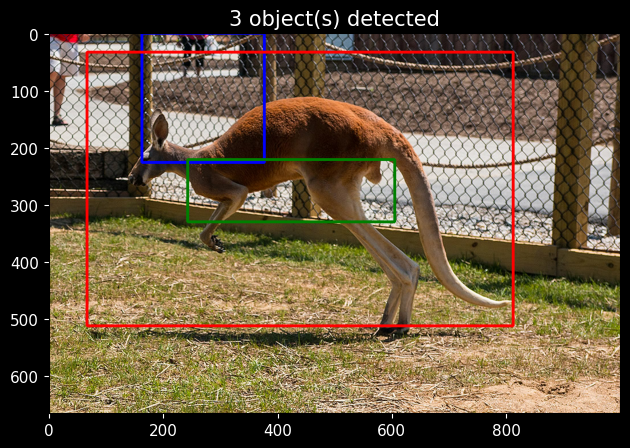

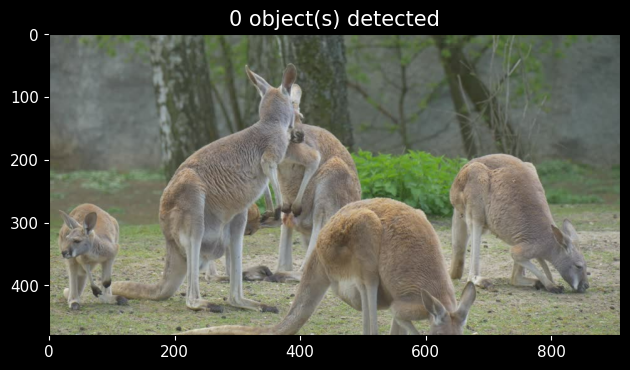

In [23]:
samples = valid.sample(5, random_state = 0)

_ = model.predict(samples, save = False, verbose = 1, obj_threshold = 0.2)

### Detection on video

The `predict` function internally calls `predict_video` for `.mp4` files. The `debug` argument allows to see time for processing, inference and saving. As you can see, for a `30sec` video, it is 2 times faster than real time (`inference time`) but saving takes a lot of time especially `save_detected = True` which saves every frame with detection boxes. If you just save video (`save_video = True`) it becomes real time (around 28sec for processing + saving). 

Note : the `MoviePy` call is to copy the audio from original video to the video with detection boxes

In [ ]:
_ = model.predict(
    'my_video.mp4', save_video = True, save_frames = False, 
    overwrite = True, verbose = 3, obj_threshold = 0.3, batch_size = 64
)

## Streaming

In [ ]:
model.stream(max_time = 5, save = True, save_boxes = True, overwrite = False)

## Configure `learning-rate scheduler`

This cell allows you to play with `learning_rate scheduler`'s parameters to get the one you want !

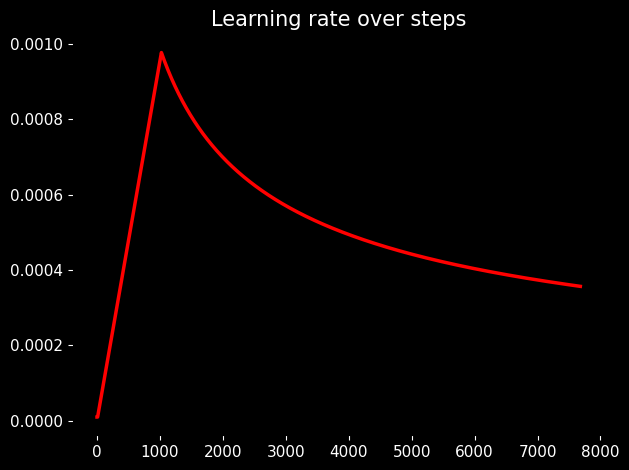

In [12]:
from custom_train_objects.optimizers import WarmupScheduler

lr = WarmupScheduler()
lr.factor = 1024.
lr.warmup_steps = 1024
lr.plot(512 * 15)

## Test dataset performances

In [15]:
config = model.get_dataset_config('valid', batch_size = 16)

ds_train = prepare_dataset(train, ** config, is_rectangular = False)

test_dataset_time(ds_train)

  8%|██████▋                                                                            | 8/100 [00:00<00:02, 42.15it/s]



8 batches generated in 189 ms (42.202 batch / sec)
- Initial batch time : 106 ms
- Average batch time : 23 ms
- Batch statistics   : [
    "shape : (10, 416, 416, 3) - min : 0.000 - max : 1.000 - mean : 0.389",
    [
        "shape : (10, 13, 13, 5, 10) - min : 0.000 - max : 12.595 - mean : 0.004",
        "shape : (10, 100, 4) - min : 0.000 - max : 12.595 - mean : 0.088"
    ]
]



{'steps': 8,
 'batch_size': 16,
 'total time': 0.18956565856933594,
 'initial batch time': 0.10691142082214355,
 'average batch time': 0.023695677518844604}